In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Import data



In [27]:
df = pd.read_csv("data.csv")
cols = ['Text', 'Sentiment', 'Timestamp', 'Likes', 'Retweets', 'Hashtags', 'Platform', 'Country']
df.head()

,Text,Sentiment,Timestamp,Likes,Retweets,Hashtags,Platform,Country
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,30.0,15.0,#Nature #Park,Twitter,USA
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,10.0,5.0,#Traffic #Morning,Twitter,Canada
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,40.0,20.0,#Fitness #Workout,Instagram,USA
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,15.0,8.0,#Travel #Adventure,Facebook,UK
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,25.0,12.0,#Cooking #Food,Instagram,Australia


In [28]:
df['Timestamp'].dtypes
# convert to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Text_Length'] = df['Text'].apply(lambda x: len(x))

In [29]:
df = df.sort_values('Timestamp',ascending=True)
df = df.reset_index(drop=True)
df.head()

,Text,Sentiment,Timestamp,Likes,Retweets,Hashtags,Platform,Country,Year,Month,Day,Hour,Text_Length
0,"Revisiting old memories, feeling a sense of e...",Elation,2010-05-15 15:30:00,40.0,20.0,#Elation #Memories,Twitter,Canada,2010,5,15,15,54
1,Contentment in the simplicity of a quiet Sund...,Contentment,2010-08-15 10:00:00,60.0,30.0,#Contentment #SundayMood,Twitter,Australia,2010,8,15,10,56
2,Contentment in the embrace of a loved one. ...,Contentment,2010-11-12 20:20:00,60.0,30.0,#Contentment #Love,Twitter,India,2010,11,12,20,54
3,"Embracing the beauty of nature, a moment of c...",Contentment,2011-06-20 14:45:00,50.0,25.0,#Contentment #Nature,Facebook,India,2011,6,20,14,58
4,Serenity found in the beauty of a sunset by t...,Serenity,2011-07-22 18:30:00,45.0,22.0,#Serenity #SunsetViews,Instagram,Canada,2011,7,22,18,55


## Preprocess
Since there are 191 unique sentiment labels, we group them into three broader categories: **positive**, **neutral**, and **negative**, to reduce feature dimensionality.

In [31]:
print(f"Number of unique sentiments: {len(df['Sentiment'].unique())}")

Number of unique sentiments: 191


In [32]:
df['Sentiment'].unique()

array(['Elation', 'Contentment', 'Serenity', 'Fulfillment', 'Gratitude',
       'Hope', 'Empowerment', 'Miscalculation', 'Grief', 'Suspense',
       'Compassion', 'Marvel', 'ArtisticBurst', 'Creativity',
       'Determination', 'Curiosity', 'Happy', 'Runway Creativity',
       'Satisfaction', 'Bitterness', 'Envisioning History', 'Tenderness',
       'Whimsy', 'Despair', 'Awe', 'Pride', 'Connection', 'Solitude',
       'Loneliness', 'Disgust', 'Contemplation', 'Darkness', 'Pressure',
       'Harmony', 'Positivity', 'Celestial Wonder', 'Boredom',
       'Appreciation', 'Inspiration', 'LostLove', 'Exploration',
       'Nostalgia', 'Betrayal', 'Resentment', 'Frustration', 'Melancholy',
       'Envy', 'Joy', 'Thrilling Journey', 'Regret', 'Arousal',
       'Obstacle', 'Wonderment', 'EmotionalStorm', 'Heartbreak',
       'Desolation', 'Captivation', 'InnerJourney', 'Mindfulness',
       'Reverence', 'Calmness', 'Success', 'Spark', 'Jealous',
       'Empathetic', 'Happiness', 'Enthusiasm', 'D

In [33]:
# sentiment mapping dictionary
positive_sentiments = { 'Elation', 'Contentment', 'Serenity', 'Gratitude', 'Hope', 'Empowerment',
    'Creativity', 'Determination', 'Curiosity', 'Happy', 'Satisfaction', 'Awe', 'Pride', 'Connection',
    'Harmony', 'Positivity', 'Appreciation', 'Inspiration', 'Joy', 'Thrilling Journey', 'Success', 'Spark',
    'Enthusiasm', 'Reflection', 'Grandeur', 'Wonder', 'Zest', 'Playful', 'Friendship', 'Excitement',
    'Euphoria', 'Adventure', 'Vibrancy', 'Romance', 'Kindness', 'Energy', 'Admiration', 'Happiness',
    'Inspired', 'Emotion', 'Proud', 'Coziness', 'Accomplishment', 'Confidence', 'Breakthrough',
    'Free-spirited', 'Colorful', 'Engagement', 'Resilience', 'Adrenaline', 'Heartwarming', 'FestiveJoy',
    'PlayfulJoy', 'Confident', 'Touched', 'DreamChaser', 'Freedom', 'Sympathy', 'Enchantment',
    'Compassionate', 'Optimism', 'Tranquility', 'Acceptance', 'Blessed', 'Rejuvenation', 'Imagination',
    'Overjoyed', 'Celebration', 'Motivation', 'Grateful', 'Solace', 'Hopeful', 'Radiance', 'Triumph',
    'Love', 'Winter Magic', 'Positive', 'Enjoyment', 'Affection', 'Adoration', 'Kind', 'Creative Inspiration',
    'Joy in Baking', 'Relief'
}

negative_sentiments = {
    'Miscalculation', 'Grief', 'Bitterness', 'Despair', 'Solitude', 'Loneliness', 'Disgust', 'Darkness',
    'Pressure', 'LostLove', 'Betrayal', 'Resentment', 'Frustration', 'Melancholy', 'Envy', 'Regret',
    'Arousal', 'Obstacle', 'EmotionalStorm', 'Heartbreak', 'Desolation', 'Desperation', 'Helplessness',
    'Loss', 'Ambivalence', 'Disappointment', 'Numbness', 'Sorrow', 'Anxiety', 'Frustrated', 'Exhaustion',
    'Intimidation', 'Fearful', 'Devastated', 'Heartache', 'Sadness', 'Anger', 'Fear', 'Sad', 'Hate', 'Bad',
    'Bitter', 'Shame', 'Embarrassed', 'Suffering'
}

neutral_sentiments = {
    'Suspense', 'Compassion', 'Marvel', 'ArtisticBurst', 'Runway Creativity', 'Envisioning History',
    'Tenderness', 'Whimsy', 'Contemplation', 'Celestial Wonder', 'Boredom', 'Nostalgia', 'Exploration',
    'Wonderment', 'Captivation', 'InnerJourney', 'Mindfulness', 'Reverence', 'Calmness', 'Dismissive',
    'Intrigue', 'Melodic', 'Whispers of the Past', 'Charm', 'Immersion', 'Surprise', 'Journey', 'Bittersweet',
    'Confusion', 'Isolation', 'Yearning', "Nature's Beauty", 'Amazement', 'Apprehensive', "Ocean's Freedom",
    'Ruins', 'Hypnotic', 'Challenge', 'Indifference', 'Neutral', 'Pensive', 'Mischievous'
}

# function of mapping
def map_sentiment(sentiment):
    if sentiment in positive_sentiments:
        return 'Positive'
    elif sentiment in negative_sentiments:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Category'] = df['Sentiment'].apply(map_sentiment)
print(df['Sentiment_Category'].value_counts())


Sentiment_Category
Positive    411
Negative    165
Neutral     156
Name: count, dtype: int64


In [34]:
df['Platform'].value_counts()

Platform
Instagram    258
Twitter      243
Facebook     231
Name: count, dtype: int64

In [35]:
df.groupby('Platform')['Sentiment_Category'].value_counts()

Platform   Sentiment_Category
Facebook   Positive              136
           Negative               52
           Neutral                43
Instagram  Positive              145
           Negative               57
           Neutral                56
Twitter    Positive              130
           Neutral                57
           Negative               56
Name: count, dtype: int64

In [36]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
import numpy as np

# Load the data
df = pd.read_csv("data.csv")

# Standardize sentiment values and drop missing values
df_clean = df.dropna(subset=['Sentiment', 'Platform', 'Retweets'])
df_clean['Sentiment'] = df_clean['Sentiment'].str.capitalize()

# -----------------------------
# Hypothesis 1: Chi-Square Test
# -----------------------------
# H0: Sentiment is independent of platform
# H1: Sentiment is dependent on platform

contingency_table = pd.crosstab(df_clean['Platform'], df_clean['Sentiment'])
chi2_stat, chi2_p, chi2_dof, chi2_expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"P-value: {chi2_p}")
if chi2_p < 0.05:
    print("Conclusion: Reject the null hypothesis — Sentiment depends on Platform.")
else:
    print("Conclusion: Fail to reject the null hypothesis — Sentiment is independent of Platform.")
print()

# -------------------------
# Hypothesis 2: T-Test
# -------------------------
# H0: Mean retweets (positive) = Mean retweets (negative)
# H1: Mean retweets (positive) ≠ Mean retweets (negative)

# Filter for sentiment groups
positive = df_clean[df_clean['Sentiment'] == 'Positive']['Retweets']
negative = df_clean[df_clean['Sentiment'] == 'Negative']['Retweets']

# Remove invalid entries
positive = positive[np.isfinite(positive)]
negative = negative[np.isfinite(negative)]

# Perform t-test
t_stat, t_p = ttest_ind(positive, negative, equal_var=False)

print("T-Test Results:")
print(f"T Statistic: {t_stat}")
print(f"P-value: {t_p}")
if t_p < 0.05:
    print("Conclusion: Reject the null hypothesis — Retweet averages differ by sentiment.")
else:
    print("Conclusion: Fail to reject the null hypothesis — No difference in retweet averages.")


Chi-Square Test Results:
Chi2 Statistic: 378.37097263002113
P-value: 0.5139527300910279
Conclusion: Fail to reject the null hypothesis — Sentiment is independent of Platform.

T-Test Results:
T Statistic: 1.0737471596703676
P-value: 0.3586456770385367
Conclusion: Fail to reject the null hypothesis — No difference in retweet averages.


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_20364\2530106698.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


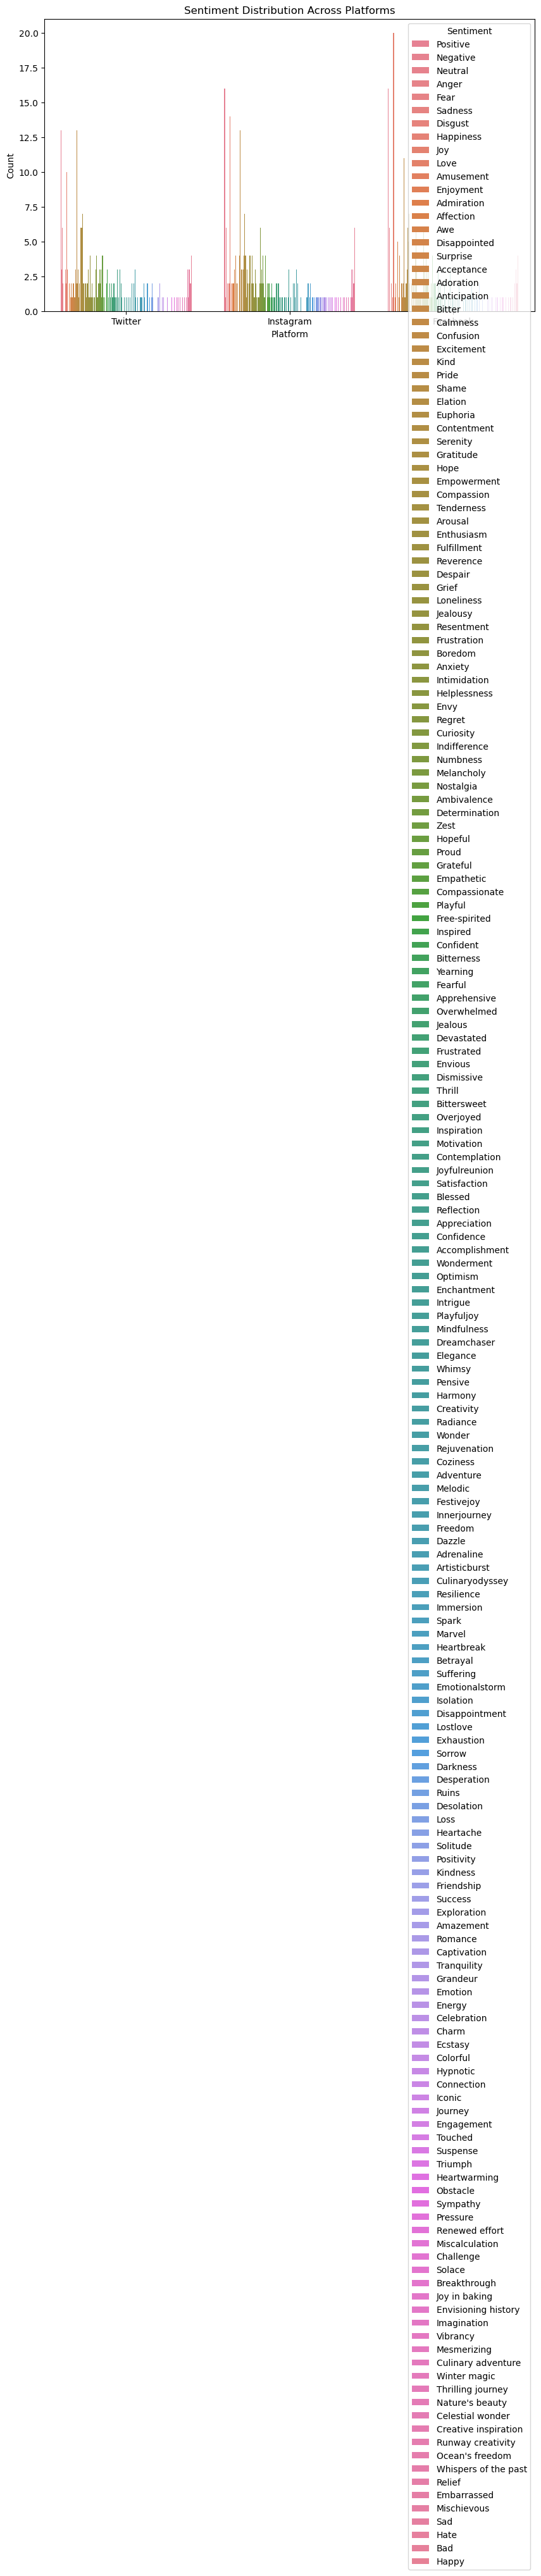

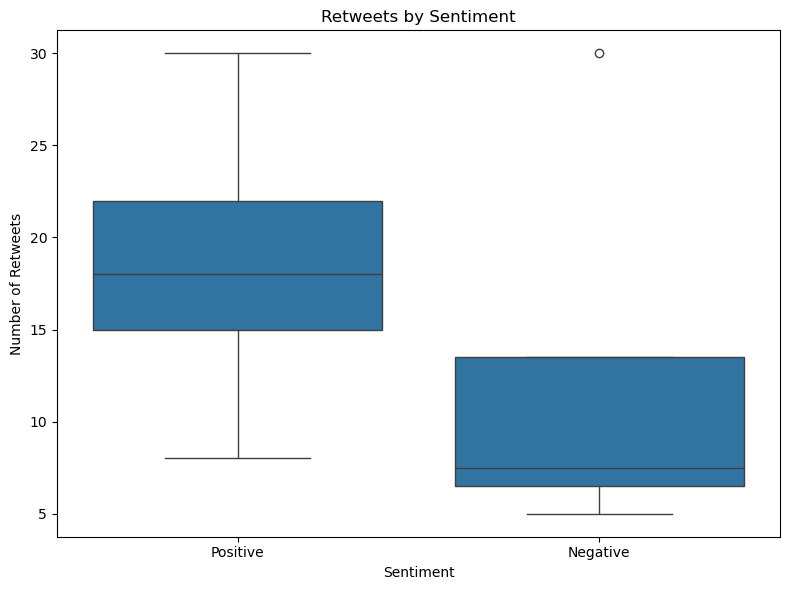

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv("data.csv")

# Clean and prepare data
df_clean = df.dropna(subset=['Sentiment', 'Platform', 'Retweets'])
df_clean['Sentiment'] = df_clean['Sentiment'].str.capitalize()

# -----------------------------
# Visualization 1: Chi-Square
# Sentiment distribution across platforms
# -----------------------------
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Platform', hue='Sentiment')
plt.title('Sentiment Distribution Across Platforms')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# -----------------------------
# Visualization 2: T-Test
# Retweets by sentiment (Positive vs Negative)
# -----------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_clean[df_clean['Sentiment'].isin(['Positive', 'Negative'])],
            x='Sentiment', y='Retweets')
plt.title('Retweets by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Retweets')
plt.tight_layout()
plt.show()
